In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 원본 파일 불러오기
dataset = pd.read_csv('data/Churn.csv')
dataset.shape

(10000, 14)

## Feature 해석하기

- 전부 결측값이 없음을 알 수 있다.

### 범주형 데이터
1. 명목형 피처 : Geography
    - Geography는 3종류 지역임을 알 수 있으며 object 타입으로 되어있다.
        - 인코딩이 필요하다.
    - 이진 피처 : Gender, HasCrCard, IsActiveMember, **Exited(target)**
        - 고윳값이 모두 2개이다.
        - Gender는 object 타입으로 되어 있지만 나머지는 int 타입으로 되어있다.
            - 인코딩이 필요하다
2. 순서형 피처 : 없음


### 수치형 데이터
1. 이산형 데이터 : NumOfProducts
    - 고윳값이 4개이다.
    - int 타입으로 되어 있다.
2. 연속형 데이터 : CreditScore, Age, Balance, EstimatedSalary
    - 고윳값이 다 다르지만 EstimatedSalary는 하나만 중복되어 있다.
    - CreditScore, Age는 int 타입, Balance, EstimatedSalary는 float 타입으로 되어있다.

---

- 그 외 데이터 : RowNumber, CustomerId, Surname
    - 필요 없는 데이터 이므로 제거하겠다.

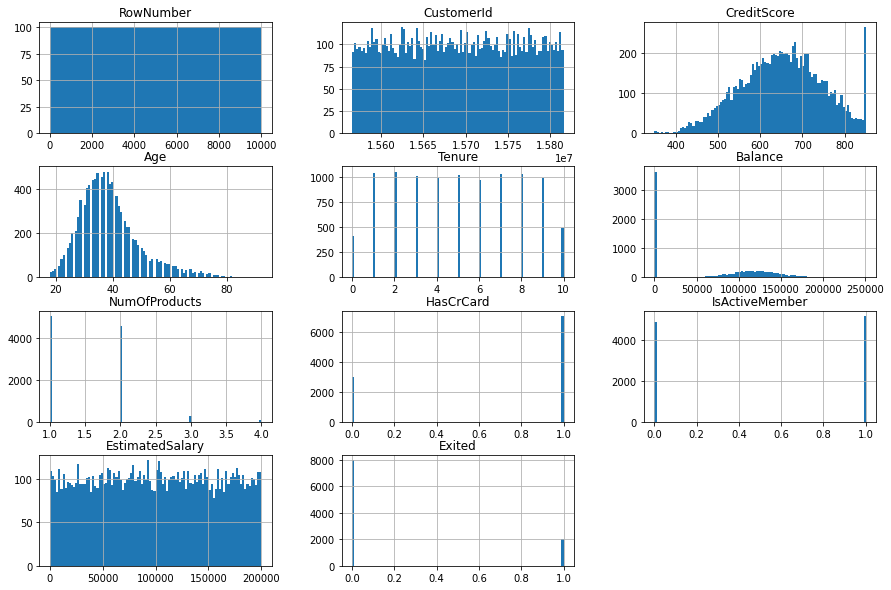

In [3]:
_ = dataset.hist(bins=100, figsize=(15, 10))

In [4]:
# feature 요약표
def resumetable(df):
    print(f'데이터셋 형상 : {df.shape}')
    summary =pd.DataFrame(df.dtypes, columns=['dtype'])\
                .reset_index().rename(columns={'index' : 'feature'})
    
    summary['null'] = df.isnull().sum().values # 결측값 개수
    summary['nunique'] = df.nunique().values # 고윳값 개수
    
    return summary

resumetable(dataset)

데이터셋 형상 : (10000, 14)


,feature,dtype,null,nunique
0,RowNumber,int64,0,10000
1,CustomerId,int64,0,10000
2,Surname,object,0,2932
3,CreditScore,int64,0,460
4,Geography,object,0,3
5,Gender,object,0,2
6,Age,int64,0,70
7,Tenure,int64,0,11
8,Balance,float64,0,6382
9,NumOfProducts,int64,0,4


In [5]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## target 분포

약 8 대 2 비율임을 알 수 있다.  
그러나 SMOTE 오버 샘플링을 쓰면 오히려 성능이 떨어진다.

In [6]:
dataset['Exited'].value_counts(normalize=True) * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

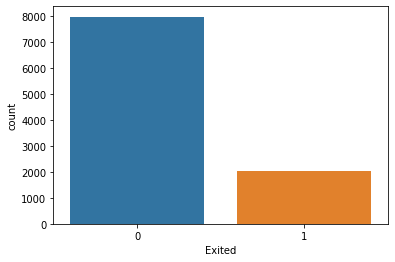

In [7]:
sns.countplot(x = 'Exited', data=dataset)
plt.show()

## 수치형 시각화

- 이산형을 제외한 CreditScore, Age, Balance, EstimatedSalary
    - CreditScore, Age, Balance는 스케일이 필요함을 알 수 있다.

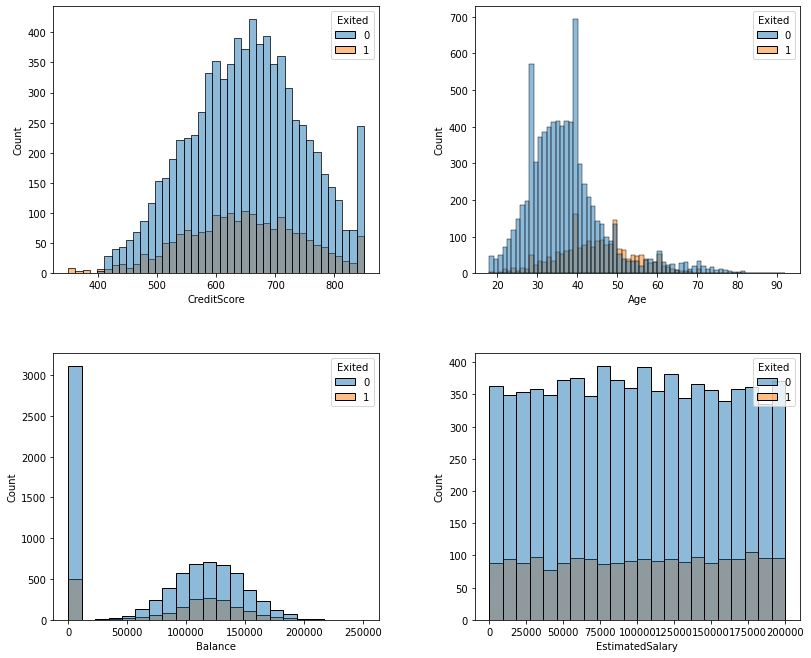

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout() # 그래프 사이에 여백 확보
fig.set_size_inches(12, 10) # 전체 크기 설정

sns.histplot(x='CreditScore', data=dataset, hue='Exited', ax=axes[0, 0])
sns.histplot(x='Age', data=dataset, hue='Exited', ax=axes[0, 1])
sns.histplot(x='Balance', data=dataset, hue='Exited', ax=axes[1, 0])
sns.histplot(x='EstimatedSalary', data=dataset, hue='Exited', ax=axes[1, 1])

plt.show()

## Feature Engineering

In [9]:
# 필요 없는 피처 제거
drop_features = ['RowNumber', 'Surname', 'CustomerId']
dataset = dataset.drop(drop_features, axis=1)

In [10]:
# 원-핫 인코딩
ohe_features = ['Geography', 'Gender']

dataset = pd.get_dummies(dataset, columns=ohe_features)

dataset.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


베이스 모델 정확도 : 0.7930

---

== scale_test 결과 ==  
{**'CreditScore_log': '0.7950', -> best1**  
 'Age_log': '0.7940',  
 'Balance_log': '0.7930',  
 **'EstimatedSalary_log': '0.8015', -> best**  
 
 **'CreditScore_std': '0.7950', -> best2**  
 'Age_std': '0.7935',  
 **'Balance_std': '0.7940', -> best**  
 'EstimatedSalary_std': '0.7935',  
 
 'CreditScore_mm': '0.7935',  
 **'Age_mm': '0.7945', -> best**  
 'Balance_mm': '0.7935',  
 'EstimatedSalary_mm': '0.7995'}
 
 ---
 
 스케일 후 모델 정확도 : 0.8485

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# CreditScore - standard 스케일링
dataset[['CreditScore']] = StandardScaler().fit_transform(dataset[['CreditScore']])

# Age - minmax 스케일링
dataset[['Age']] = MinMaxScaler().fit_transform(dataset[['Age']])

# Balance - standard 스케일링
dataset[['Balance']] = StandardScaler().fit_transform(dataset[['Balance']])

# EstimatedSalary - log 스케일링
dataset['EstimatedSalary'] = np.log1p(dataset['EstimatedSalary'])

# Baseline model

1. 환경 설정
    - 시드값 고정
    - target 지정
2. 데이터 준비
    - 훈련/학습 데이터 분리
3. 모델 구성
5. 성능 검증
6. 예측 및 제출

In [12]:
import tensorflow as tf

# 시드값 고정
seed = 42
# target 지정
label_name = 'Exited'

In [17]:
def modeling(dataset):
    # train set, test set 나누기
    X_train = dataset.sample(frac = 0.8, random_state = seed)
    X_test = dataset.drop(X_train.index)
    
    # target 나누기
    y_train = X_train.pop(label_name)
    y_test = X_test.pop(label_name)
    
    # input shape
    input_shape = len(X_train.keys())
    
    # 모델 구성
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=[input_shape]),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

    # 모델 훈련
    history = model.fit(X_train, y_train, epochs=1000000, callbacks=[early_stop], verbose=0)
    hist = pd.DataFrame(history.history)
    
    # hist 시각화
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    hist[['loss']].plot(ax=axes[0])
    hist[['accuracy']].plot(ax=axes[1])
    plt.show()
    
    # 정확도 평가
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    return f'{test_acc:.4f}'

In [14]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm

cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

def scale_test(df, cols):
    """좋은 성능을 내는 스케일링 찾기"""
    
    sacle_acc = {}
    
    # log 스케일링
    for col in tqdm(cols):
        dataset = df.copy()
        dataset[col] = np.log1p(dataset[col])
        sacle_acc[f'{col}_log'] = modeling(dataset)
        
    # standard 스케일링
    for col in tqdm(cols):
        dataset = df.copy()
        dataset[[col]] = StandardScaler().fit_transform(dataset[[col]])
        sacle_acc[f'{col}_std'] = modeling(dataset)
    
    # minmax 스케일링
    for col in tqdm(cols):
        dataset = df.copy()
        dataset[[col]] = MinMaxScaler().fit_transform(dataset[[col]])
        sacle_acc[f'{col}_mm'] = modeling(dataset)
    
    return sacle_acc

In [15]:
# scale_test(dataset, cols)

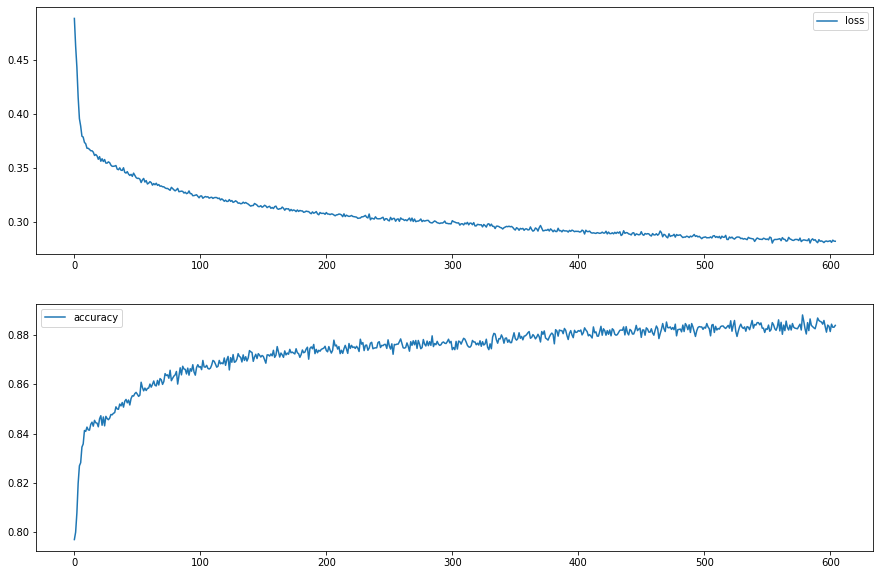

'0.8485'

In [18]:
# 최종 스케일링 후 모델링
modeling(dataset)